### Creation of the MOBILENET Model using the Original Data

Epoch 1/100


/home/suresh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.2628 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: 0.0991 - accuracy_class_6: nan - loss: 3.6841

/home/suresh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 567ms/step - accuracy: 0.2630 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: 0.0991 - accuracy_class_6: nan - loss: 3.6831 - val_accuracy: 0.5357 - val_accuracy_class_0: nan - val_accuracy_class_1: nan - val_accuracy_class_2: nan - val_accuracy_class_3: nan - val_accuracy_class_4: nan - val_accuracy_class_5: 0.0448 - val_accuracy_class_6: nan - val_loss: 2.8658 - learning_rate: 1.0000e-04
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 597ms/step - accuracy: 0.4153 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: 0.0798 - accuracy_class_6: nan - loss: 2.8154 - val_accuracy: 0.5696 - val_accuracy_class_0: nan - val_accuracy_class_1: nan - val_accuracy_class_2: nan - val_accuracy_class_3: nan - val_accuracy_class_4: nan - val_accuracy_class_5: 0.0507 - val_accuracy_class_6: n

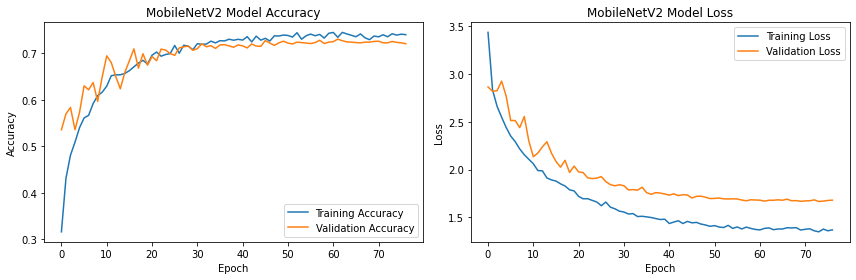

In [50]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import albumentations as A

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

# Paths and parameters
image_folder = "../data/HAM10000_images"
segmentation_folder = "../data/HAM10000_seg_masks"
metadata_file = "../data/HAM10000_metadata.csv"

# Consistent parameters
image_size = 224
batch_size = 32
epochs = 100

class CustomImageGeneratorWithMask(tf.keras.utils.Sequence):
    def __init__(self, image_ids, labels, batch_size, label_encoder, augment=False):
        self.image_ids = image_ids
        self.labels = labels
        self.batch_size = batch_size
        self.label_encoder = label_encoder
        self.augment = augment

        # Updated Albumentations augmentation pipeline
        self.augmentation = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2)
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        batch_original_images = []
        batch_segmented_images = []
        batch_labels = []

        for image_id in batch_image_ids:
            # Paths for image and segmentation mask
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            mask_path = os.path.join(segmentation_folder, f"{image_id}_segmentation.png")

            # Read original and mask images
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize images
            original_image = cv2.resize(original_image, (image_size, image_size))
            mask = cv2.resize(mask, (image_size, image_size))

            # Apply augmentations if training
            if self.augment:
                # Apply augmentation separately to image and mask
                augmented_image = self.augmentation(image=original_image)['image']
                augmented_mask = self.augmentation(image=mask)['image']
                
                original_image = augmented_image
                mask = augmented_mask

            # Create segmented image
            mask_3ch = cv2.merge([mask] * 3)
            segmented_image = cv2.addWeighted(original_image, 0.8, mask_3ch, 0.2, 0)

            batch_original_images.append(original_image)
            batch_segmented_images.append(segmented_image)

            # Get label and encode
            label = self.labels.get(image_id, None)
            batch_labels.append(label)

        # Preprocess images for MobileNetV2
        batch_original_images = preprocess_input(np.array(batch_original_images))
        batch_segmented_images = preprocess_input(np.array(batch_segmented_images))

        # Convert labels to categorical
        batch_labels = self.label_encoder.transform(batch_labels)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.label_encoder.classes_))

        return (batch_original_images, batch_segmented_images), batch_labels


def create_classwise_accuracy_metrics(num_classes):
    class_metrics = []
    for i in range(num_classes):
        def get_class_accuracy(i):
            def class_accuracy(y_true, y_pred):
                class_pred = tf.argmax(y_pred, axis=-1)
                class_true = tf.argmax(y_true, axis=-1)
                class_mask = tf.equal(class_true, i)
                class_acc = tf.reduce_mean(
                    tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_mask[class_mask], tf.int64)), tf.float32)
                )
                return class_acc
            class_accuracy.__name__ = f'accuracy_class_{i}'
            return class_accuracy
        class_metrics.append(get_class_accuracy(i))
    return class_metrics

def step_decay_schedule(initial_lr=0.0001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    return LearningRateScheduler(schedule)

# Load metadata
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])

# Create label dictionary
labels = dict(zip(metadata["image_id"], metadata["dx"]))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=label_encoder.classes_,
    y=metadata["dx"].values
)
class_weights_dict = dict(enumerate(class_weights))

# Split the dataset
image_ids = metadata["image_id"].values
train_image_ids, val_image_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create data generators with augmentation
train_generator = CustomImageGeneratorWithMask(
    train_image_ids, labels, batch_size, label_encoder, augment=True
)
val_generator = CustomImageGeneratorWithMask(
    val_image_ids, labels, batch_size, label_encoder, augment=False
)

# Create MobileNetV2 models with unique names
base_model_original = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(image_size, image_size, 3),
    name="mobilenetv2_original"  # Unique name for original input
)

base_model_segmented = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(image_size, image_size, 3),
    name="mobilenetv2_segmented"  # Unique name for segmented input
)

# Freeze base models initially
base_model_original.trainable = False
base_model_segmented.trainable = False

# Define input layers
input_original = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="original_input")
input_segmented = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="segmented_input")

# Pass through separate MobileNetV2 models
features_original = base_model_original(input_original)
features_segmented = base_model_segmented(input_segmented)

# Concatenate features
combined_features = tf.keras.layers.Concatenate()([
    tf.keras.layers.GlobalAveragePooling2D()(features_original),
    tf.keras.layers.GlobalAveragePooling2D()(features_segmented)
])

# Add custom classification layers
x = tf.keras.layers.Dense(1024, activation="relu", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))(combined_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(
    len(label_encoder.classes_), 
    activation="softmax",
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
)(x)

# Create and compile the model
model = tf.keras.Model(inputs=[input_original, input_segmented], outputs=output)

# Prepare metrics (including class-wise accuracy)
metrics = ['accuracy'] + create_classwise_accuracy_metrics(len(label_encoder.classes_))

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss="categorical_crossentropy", 
    metrics=metrics
)

# Callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "mobilenet_classification_model.keras", 
    save_best_only=True, 
    monitor="val_accuracy", 
    mode="max"
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=15, 
    restore_best_weights=True
)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=7, 
    min_lr=0.000005
)


# Modify callbacks to include learning rate scheduler
lr_scheduler = step_decay_schedule(initial_lr=0.0001, decay_factor=0.5, step_size=10)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[
        checkpoint_callback, 
        early_stopping_callback, 
        reduce_lr_callback,
        lr_scheduler
    ]
)

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('mobilenet_training_history.png')

# Save the final model
model.save("mobilenet_classification_model.keras")

# Print label mapping and class-wise metrics
print("\nLabel Mapping:")
print(dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_)))

# Evaluate on validation set
val_metrics = model.evaluate(val_generator)
print("\nValidation Metrics:")
for metric_name, metric_value in zip(model.metrics_names, val_metrics):
    print(f"{metric_name}: {metric_value}")

In [56]:
# Save the model
model.save("mobilenet_classification_model.keras")

# Load the model with registered custom metrics
custom_objects = {f'accuracy_class_{i}': create_classwise_accuracy_metrics(len(label_encoder.classes_))[i] 
                  for i in range(len(label_encoder.classes_))}

model = tf.keras.models.load_model("../mobilenet_classification_model.keras", custom_objects=custom_objects)


### Testing the model with a sample test image

In [61]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the label encoder
metadata_file = "../data/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])

# Register custom metrics
custom_metrics = {}

for i in range(len(label_encoder.classes_)):
    @tf.keras.utils.register_keras_serializable(package="Custom")
    def class_accuracy(y_true, y_pred, class_index=i):
        class_pred = tf.argmax(y_pred, axis=-1)
        class_true = tf.argmax(y_true, axis=-1)
        class_mask = tf.equal(class_true, class_index)
        acc = tf.reduce_mean(
            tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_true[class_mask], tf.int64)), tf.float32)
        )
        return acc

    class_accuracy.__name__ = f"accuracy_class_{i}"
    custom_metrics[class_accuracy.__name__] = class_accuracy

# Load the model with custom objects
model = load_model("../mobilenet_classification_model.keras", custom_objects=custom_metrics)

# Paths for testing
test_image_path = "../data/HAM10000_images/ISIC_0024316.jpg"  # Replace with the path to the image you want to test
test_mask_path = "../data/HAM10000_seg_masks/ISIC_0024316_segmentation.png"  # Replace with the path to the corresponding mask image

# Preprocess the test image and mask
image_size = 224

# Load and preprocess test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (image_size, image_size))

# Load and preprocess test mask
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (image_size, image_size))
test_mask_3ch = cv2.merge([test_mask] * 3)

# Combine image and mask
test_segmented_image = cv2.addWeighted(test_image, 0.8, test_mask_3ch, 0.2, 0)

# Preprocess for MobileNetV2
test_image = preprocess_input(np.expand_dims(test_image, axis=0))
test_segmented_image = preprocess_input(np.expand_dims(test_segmented_image, axis=0))

# Make predictions
predictions = model.predict([test_image, test_segmented_image])

# Decode predictions
predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
print("Predicted label:", predicted_label)

# Print prediction probabilities for all classes
class_probabilities = dict(zip(label_encoder.classes_, predictions[0]))
print("\nClass probabilities:")
res = []
for cls, prob in class_probabilities.items():
    print(f"{cls}: {prob:.4f}")
    res.append(prob)
print('Avg. Class Accuracy:', sum(res)/7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: ['nv']

Class probabilities:
akiec: 0.0045
bcc: 0.0012
bkl: 0.0023
df: 0.0093
mel: 0.0018
nv: 0.9802
vasc: 0.0006
Avg. Class Accuracy: 0.14285715762525797


### Creation of the MOBILENET Model using the Augumented Data

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import albumentations as A

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

# Updated Paths and parameters
image_folder = "../augment_data/augmented_images"
segmentation_folder = "../augment_data/augmented_masks"
metadata_file = "../augment_data/augmented_metadata.csv"

# Consistent parameters
image_size = 224
batch_size = 32
epochs = 100

class CustomImageGeneratorWithMask(tf.keras.utils.Sequence):
    def __init__(self, image_ids, labels, batch_size, label_encoder, augment=False):
        # Validate and filter image files
        self.valid_image_ids = []
        for image_id in image_ids:
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            mask_path = os.path.join(segmentation_folder, f"{image_id}_segmentation.png")
            
            if os.path.exists(image_path) and os.path.exists(mask_path):
                self.valid_image_ids.append(image_id)
            else:
                print(f"Warning: Missing files for {image_id}")
        
        self.image_ids = self.valid_image_ids
        self.labels = labels
        self.batch_size = batch_size
        self.label_encoder = label_encoder
        self.augment = augment

        # Updated Albumentations augmentation pipeline
        self.augmentation = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2)
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        batch_original_images = []
        batch_segmented_images = []
        batch_labels = []

        for image_id in batch_image_ids:
            # Paths for image and segmentation mask
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            mask_path = os.path.join(segmentation_folder, f"{image_id}_segmentation.png")

            # Read original and mask images with error handling
            try:
                original_image = cv2.imread(image_path)
                if original_image is None:
                    print(f"Failed to read image: {image_path}")
                    continue
                
                original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"Failed to read mask: {mask_path}")
                    continue

                # Resize images
                original_image = cv2.resize(original_image, (image_size, image_size))
                mask = cv2.resize(mask, (image_size, image_size))

                # Apply augmentations if training
                if self.augment:
                    # Apply augmentation separately to image and mask
                    augmented_image = self.augmentation(image=original_image)['image']
                    augmented_mask = self.augmentation(image=mask)['image']
                    
                    original_image = augmented_image
                    mask = augmented_mask

                # Create segmented image
                mask_3ch = cv2.merge([mask] * 3)
                segmented_image = cv2.addWeighted(original_image, 0.8, mask_3ch, 0.2, 0)

                batch_original_images.append(original_image)
                batch_segmented_images.append(segmented_image)

                # Get label and encode
                label = self.labels.get(image_id, None)
                batch_labels.append(label)

            except Exception as e:
                print(f"Error processing {image_id}: {e}")
                continue

        # Preprocess images for MobileNetV2
        batch_original_images = preprocess_input(np.array(batch_original_images))
        batch_segmented_images = preprocess_input(np.array(batch_segmented_images))

        # Convert labels to categorical
        batch_labels = self.label_encoder.transform(batch_labels)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.label_encoder.classes_))

        return (batch_original_images, batch_segmented_images), batch_labels


def create_classwise_accuracy_metrics(num_classes):
    class_metrics = []
    for i in range(num_classes):
        def get_class_accuracy(i):
            def class_accuracy(y_true, y_pred):
                class_pred = tf.argmax(y_pred, axis=-1)
                class_true = tf.argmax(y_true, axis=-1)
                class_mask = tf.equal(class_true, i)
                class_acc = tf.reduce_mean(
                    tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_mask[class_mask], tf.int64)), tf.float32)
                )
                return class_acc
            class_accuracy.__name__ = f'accuracy_class_{i}'
            return class_accuracy
        class_metrics.append(get_class_accuracy(i))
    return class_metrics

def step_decay_schedule(initial_lr=0.0001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    return LearningRateScheduler(schedule)

# Load metadata
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])

# Create label dictionary
labels = dict(zip(metadata["image_id"], metadata["dx"]))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=label_encoder.classes_,
    y=metadata["dx"].values
)
class_weights_dict = dict(enumerate(class_weights))

# Split the dataset
image_ids = metadata["image_id"].values
train_image_ids, val_image_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create data generators with augmentation
train_generator = CustomImageGeneratorWithMask(
    train_image_ids, labels, batch_size, label_encoder, augment=True
)
val_generator = CustomImageGeneratorWithMask(
    val_image_ids, labels, batch_size, label_encoder, augment=False
)

# Create MobileNetV2 models with unique names
base_model_original = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(image_size, image_size, 3),
    name="mobilenetv2_original"
)

base_model_segmented = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(image_size, image_size, 3),
    name="mobilenetv2_segmented"
)

# Freeze base models initially
base_model_original.trainable = False
base_model_segmented.trainable = False

# Define input layers
input_original = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="original_input")
input_segmented = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="segmented_input")

# Pass through separate MobileNetV2 models
features_original = base_model_original(input_original)
features_segmented = base_model_segmented(input_segmented)

# Concatenate features
combined_features = tf.keras.layers.Concatenate()([
    tf.keras.layers.GlobalAveragePooling2D()(features_original),
    tf.keras.layers.GlobalAveragePooling2D()(features_segmented)
])

# Add custom classification layers
x = tf.keras.layers.Dense(1024, activation="relu", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))(combined_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(
    len(label_encoder.classes_), 
    activation="softmax",
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
)(x)

# Path to the saved model
model_path = "../mobilenet_classification_model.keras"

from keras.models import load_model

# Recreate the custom metrics
def get_class_accuracy(i):
    def class_accuracy(y_true, y_pred):
        class_pred = tf.argmax(y_pred, axis=-1)
        class_true = tf.argmax(y_true, axis=-1)
        class_mask = tf.equal(class_true, i)
        class_acc = tf.reduce_mean(
            tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_mask[class_mask], tf.int64)), tf.float32)
        )
        return class_acc
    class_accuracy.__name__ = f'accuracy_class_{i}'
    return class_accuracy

custom_objects = {
    f"accuracy_class_{i}": get_class_accuracy(i)
    for i in range(len(label_encoder.classes_))
}

# Load the model
model = load_model(model_path, custom_objects=custom_objects)


# Prepare metrics (including class-wise accuracy)
metrics = ['accuracy'] + create_classwise_accuracy_metrics(len(label_encoder.classes_))

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss="categorical_crossentropy", 
    metrics=metrics
)

# Callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "new_mobilenet_classification_model.keras", 
    save_best_only=False, 
    monitor="val_accuracy", 
    mode="max", 
    save_weights_only=False,
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=15, 
    restore_best_weights=True
)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=7, 
    min_lr=0.000005
)

# Modify callbacks to include learning rate scheduler
lr_scheduler = step_decay_schedule(initial_lr=0.0001, decay_factor=0.5, step_size=10)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[
        checkpoint_callback, 
        early_stopping_callback, 
        reduce_lr_callback,
        lr_scheduler
    ]
)

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('mobilenet_training_history.png')

# Save the final model
model.save("mobilenet_classification_model.keras")

# Print label mapping and class-wise metrics
print("\nLabel Mapping:")
print(dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_)))

# Evaluate on validation set
val_metrics = model.evaluate(val_generator)
print("\nValidation Metrics:")
for metric_name, metric_value in zip(model.metrics_names, val_metrics):
    print(f"{metric_name}: {metric_value}")

Epoch 1/100


/home/suresh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6913 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: nan - accuracy_class_6: nan - loss: 1.9793

/home/suresh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: saving model to new_mobilenet_classification_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 511s 429ms/step - accuracy: 0.6913 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: nan - accuracy_class_6: nan - loss: 1.9792 - val_accuracy: 0.8010 - val_accuracy_class_0: nan - val_accuracy_class_1: 0.7663 - val_accuracy_class_2: nan - val_accuracy_class_3: nan - val_accuracy_class_4: nan - val_accuracy_class_5: nan - val_accuracy_class_6: nan - val_loss: 1.4933 - learning_rate: 1.0000e-04
Epoch 2/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7338 - accuracy_class_0: nan - accuracy_class_1: nan - accuracy_class_2: nan - accuracy_class_3: nan - accuracy_class_4: nan - accuracy_class_5: nan - accuracy_class_6: nan - loss: 1.6288
Epoch 2: saving model to new_mobilenet_classification_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 523s 444ms/step - accuracy: 0.7338 - accuracy_class_0: nan 

### Results & Metrics

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.models import load_model

# Paths to necessary files
model_path = "../new_mobilenet_classification_model.keras"
metadata_file = "../augment_data/augmented_metadata.csv"
image_folder = "../augment_data/augmented_images"
segmentation_folder = "../augment_data/augmented_masks"

# Parameters
image_size = 224
batch_size = 32

# Load metadata and encode labels
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])


# Recreate the custom metrics
def get_class_accuracy(i):
    def class_accuracy(y_true, y_pred):
        class_pred = tf.argmax(y_pred, axis=-1)
        class_true = tf.argmax(y_true, axis=-1)
        class_mask = tf.equal(class_true, i)
        class_acc = tf.reduce_mean(
            tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_mask[class_mask], tf.int64)), tf.float32)
        )
        return class_acc
    class_accuracy.__name__ = f'accuracy_class_{i}'
    return class_accuracy

custom_objects = {
    f"accuracy_class_{i}": get_class_accuracy(i)
    for i in range(len(label_encoder.classes_))
}

# Load the model
model = load_model(model_path, custom_objects=custom_objects)

In [3]:
# Calculate recall for each class
confusion_matrix = np.array(conf_matrix)
recalls = []
for i in range(confusion_matrix.shape[0]):
    recall_i = confusion_matrix[i, i] / np.sum(confusion_matrix[i])
    recalls.append(recall_i)

# Calculate average recall
average_recall = np.mean(recalls)

# Print results
for i, recall in enumerate(recalls):
    print(f"Recall for class {i}: {recall:.3f}")
    
print(f"\nAverage Recall: {average_recall:.3f}")

Recall for class 0: 0.583
Recall for class 1: 0.704
Recall for class 2: 0.790
Recall for class 3: 0.749
Recall for class 4: 0.518
Recall for class 5: 0.757
Recall for class 6: 0.972

Average Recall: 0.725


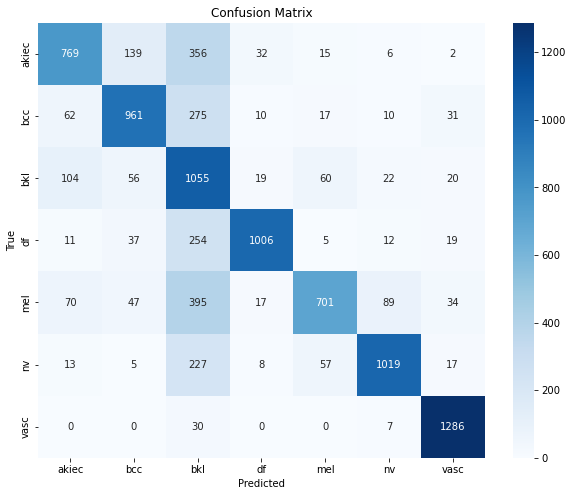

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# cm = confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Using label_encoder.classes_ to get the class labels
class_labels = label_encoder.classes_

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [6]:
label_encoder.classes_

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

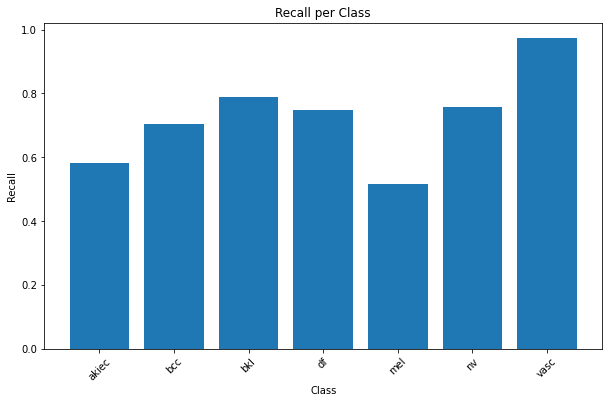

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Class labels (replace this with your actual class labels)
labels = label_encoder.classes_

# Compute recall for each class
recall_per_class = recall_score(y_true, y_pred, average=None)

# Plot recall for each class
plt.figure(figsize=(10, 6))
plt.bar(range(len(recall_per_class)), recall_per_class)
plt.xticks(range(len(recall_per_class)), labels, rotation=45)  # Using labels for x-axis
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.show()


### Model Summary

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ original_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segmented_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_origin… │ (None, 7, 7,      │  2,257,984 │ original_input[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_segmen… │ (None, 7, 7,      │  2,257,984 │ segmented_input[… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_orig… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_segm… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,622,464 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │      7,175 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,413,079 (47.35 MB)

 Trainable params: 2,631,687 (10.04 MB)

 Non-trainable params: 4,518,016 (17.23 MB)

 Optimizer params: 5,263,376 (20.08 MB)

### Testing the NEW MOBILENET Model (Trianed on the Augumented Data) with a sample image 

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the Metadata & Label Encoder
metadata_file = "../augment_data/augmented_metadata.csv"
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])

# Register custom metrics
custom_metrics = {}

for i in range(len(label_encoder.classes_)):
    @tf.keras.utils.register_keras_serializable(package="Custom")
    def class_accuracy(y_true, y_pred, class_index=i):
        class_pred = tf.argmax(y_pred, axis=-1)
        class_true = tf.argmax(y_true, axis=-1)
        class_mask = tf.equal(class_true, class_index)
        acc = tf.reduce_mean(
            tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_true[class_mask], tf.int64)), tf.float32)
        )
        return acc

    class_accuracy.__name__ = f"accuracy_class_{i}"
    custom_metrics[class_accuracy.__name__] = class_accuracy

# Load the model with custom objects
model = load_model("../new_mobilenet_classification_model.keras", custom_objects=custom_metrics)

# Testing Images
test_image_path = "../data/HAM10000_images/ISIC_0024316.jpg"  # Replace with the path to the image you want to test
test_mask_path = "../data/HAM10000_seg_masks/ISIC_0024316_segmentation.png"  # Replace with the path to the corresponding mask image

# Preprocess the test image and mask
image_size = 224

# Load and preprocess test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (image_size, image_size))

# Load and preprocess test mask
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (image_size, image_size))
test_mask_3ch = cv2.merge([test_mask] * 3)

# Combine image and mask
test_segmented_image = cv2.addWeighted(test_image, 0.8, test_mask_3ch, 0.2, 0)

# Preprocess for MobileNetV2
test_image = preprocess_input(np.expand_dims(test_image, axis=0))
test_segmented_image = preprocess_input(np.expand_dims(test_segmented_image, axis=0))

# Make predictions
predictions = model.predict([test_image, test_segmented_image])

# Decode predictions
predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
print("Predicted label:", predicted_label)

# Print prediction probabilities for all classes
class_probabilities = dict(zip(label_encoder.classes_, predictions[0]))
print("\nClass probabilities:")
res = []
for cls, prob in class_probabilities.items():
    print(f"{cls}: {prob:.4f}")
    res.append(prob)
print('Avg. Class Accuracy:', sum(res)/7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: ['nv']

Class probabilities:
akiec: 0.0006
bcc: 0.0001
bkl: 0.0009
df: 0.0032
mel: 0.0009
nv: 0.9943
vasc: 0.0000
Avg. Class Accuracy: 0.14285713224866672


### More Testing Samples

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Loading the metadata
metadata_file = "../augment_data/augmented_metadata.csv"
metadata = pd.read_csv(metadata_file)
label_encoder = LabelEncoder()
label_encoder.fit(metadata["dx"])

# Register custom metrics
custom_metrics = {}

for i in range(len(label_encoder.classes_)):
    @tf.keras.utils.register_keras_serializable(package="Custom")
    def class_accuracy(y_true, y_pred, class_index=i):
        class_pred = tf.argmax(y_pred, axis=-1)
        class_true = tf.argmax(y_true, axis=-1)
        class_mask = tf.equal(class_true, class_index)
        acc = tf.reduce_mean(
            tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_true[class_mask], tf.int64)), tf.float32)
        )
        return acc

    class_accuracy.__name__ = f"accuracy_class_{i}"
    custom_metrics[class_accuracy.__name__] = class_accuracy

# Load the model with custom objects
model = load_model("../new_mobilenet_classification_model.keras", custom_objects=custom_metrics)


# test_image_path = "../data/HAM10000_images/ISIC_0024316.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../data/HAM10000_seg_masks/ISIC_0024316_segmentation.png"  # Replace with the path to the corresponding mask image

# test_image_path = "../augment_data/augmented_images/ISIC_0025350_aug_829.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0025350_aug_829_segmentation.png"  # Replace with the path to the corresponding mask image


# test_image_path = "../augment_data/augmented_images/ISIC_0030283_aug_1085.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0030283_aug_1085_segmentation.png"  # Replace with the path to the corresponding mask image

# test_image_path = "../augment_data/augmented_images/ISIC_0028087_aug_4654.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0028087_aug_4654_segmentation.png"  # Replace with the path to the corresponding mask image

test_image_path = "../augment_data/augmented_images/ISIC_0034223_aug_1728.jpg"  # Replace with the path to the image you want to test
test_mask_path = "../augment_data/augmented_masks/ISIC_0034223_aug_1728_segmentation.png"  # Replace with the path to the corresponding mask image

# test_image_path = "../augment_data/augmented_images/ISIC_0028651_aug_5732.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0028651_aug_5732_segmentation.png"  # Replace with the path to the corresponding mask image

# test_image_path = "../augment_data/augmented_images/ISIC_0027419_aug_1099.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0027419_aug_1099_segmentation.png"  # Replace with the path to the corresponding mask image

# test_image_path = "../augment_data/augmented_images/ISIC_0030690_aug_6005.jpg"  # Replace with the path to the image you want to test
# test_mask_path = "../augment_data/augmented_masks/ISIC_0030690_aug_6005_segmentation.png"  # Replace with the path to the corresponding mask image

# Preprocess the test image and mask
image_size = 224

# Load and preprocess test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (image_size, image_size))

# Load and preprocess test mask
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (image_size, image_size))
test_mask_3ch = cv2.merge([test_mask] * 3)

# Combine image and mask
test_segmented_image = cv2.addWeighted(test_image, 0.8, test_mask_3ch, 0.2, 0)

# Preprocess for MobileNetV2
test_image = preprocess_input(np.expand_dims(test_image, axis=0))
test_segmented_image = preprocess_input(np.expand_dims(test_segmented_image, axis=0))

# Make predictions
predictions = model.predict([test_image, test_segmented_image])

# Decode predictions
predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
print("Predicted label:", predicted_label)

# Print prediction probabilities for all classes
class_probabilities = dict(zip(label_encoder.classes_, predictions[0]))
print("\nClass probabilities:")
res = []
for cls, prob in class_probabilities.items():
    print(f"{cls}: {prob:.4f}")
    res.append(prob)
print('Avg. Class Accuracy:', sum(res)/7)

### Final Model Function code which is used in the APP

In [ ]:
def mobileNetPrediction(image_path) -> None:
    import tensorflow as tf
    from tensorflow.keras.models import load_model
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    import cv2
    import numpy as np
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

    # Load metadata and initialize Label Encoder
    metadata_file = "../augment_data/augmented_metadata.csv"
    metadata = pd.read_csv(metadata_file)
    label_encoder = LabelEncoder()
    label_encoder.fit(metadata["dx"])
    image_size = 224

    # Register Custom Metrics
    custom_metrics = {}

    for i in range(len(label_encoder.classes_)):
        def class_accuracy(y_true, y_pred, class_index=i):
            class_pred = tf.argmax(y_pred, axis=-1)
            class_true = tf.argmax(y_true, axis=-1)
            class_mask = tf.equal(class_true, class_index)
            acc = tf.reduce_mean(
                tf.cast(tf.equal(class_pred[class_mask], tf.cast(class_true[class_mask], tf.int64)), tf.float32)
            )
            return acc

        # Ensure each function is uniquely named and registered
        metric_name = f"accuracy_class_{i}"
        class_accuracy.__name__ = metric_name
        tf.keras.utils.register_keras_serializable(package="Custom")(class_accuracy)
        custom_metrics[metric_name] = class_accuracy

    # Paths to models
    segmentation_model_path = "../HAM10000_segmentation_model.h5"
    classification_model_path = "../new_mobilenet_classification_model.keras"

    # Load Models
    segmentation_model = tf.keras.models.load_model(segmentation_model_path)
    classification_model = load_model(
        classification_model_path,
        custom_objects=custom_metrics  # Provide the registered custom metrics
    )

    print("Models loaded successfully!")

    # Preprocessing Functions
    def hair_removal(image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
        _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        return cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    def preprocess_image(image_path):
        image = cv2.imread(image_path)
        image = cv2.resize(hair_removal(image), (image_size, image_size))
        image = cv2.resize(image, (image_size, image_size))
        return image / 255.0  # Normalize to [0, 1]

    def get_largest_contiguous_region(mask, threshold=0.5):
        binary_mask = (mask > threshold).astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Offset by 1 for background
        largest_region = (labels == largest_label).astype(np.uint8)
        return largest_region
    
    # Prediction Pipeline
    def predict_classification(image_path):
        # Preprocess image
        input_image = preprocess_image(image_path)
        # Ensure input_image is in float32 and within range [0, 1]
        input_image = input_image.astype(np.float32)

        input_image_expanded = np.expand_dims(input_image, axis=0)
        
        # Generate mask using segmentation model
        predicted_mask = segmentation_model.predict(input_image_expanded)[0, :, :, 0]
        largest_region_mask = get_largest_contiguous_region(predicted_mask)
        largest_region_mask_resized = cv2.resize(largest_region_mask, (image_size, image_size))
        largest_region_mask_3ch = cv2.merge([largest_region_mask_resized] * 3)
        
        # Combine image and mask
        largest_region_mask_3ch = largest_region_mask_3ch.astype(np.float32) / 255.0  # Normalize to [0, 1]
        largest_region_mask_3ch = cv2.resize(largest_region_mask_3ch, (input_image.shape[1], input_image.shape[0]))


        combined_image = cv2.addWeighted(input_image, 0.8, largest_region_mask_3ch, 0.2, 0)
        
        # Preprocess inputs for classification model
        input_image_preprocessed = preprocess_input(np.expand_dims(input_image * 255.0, axis=0))
        combined_image_preprocessed = preprocess_input(np.expand_dims(combined_image * 255.0, axis=0))
        
        # Predict using classification model
        predictions = classification_model.predict([input_image_preprocessed, combined_image_preprocessed])
        predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
        
        # Class probabilities
        class_probabilities = dict(zip(label_encoder.classes_, predictions[0]))
        
        return predicted_label[0], class_probabilities
    
    
    predicted_label, class_probabilities = predict_classification(image_path)

    print("Predicted label:", predicted_label)
    print("\nClass probabilities:")
    for cls, prob in class_probabilities.items():
        print(f"{cls}: {prob:.4f}")


image_path = "../augment_data/augmented_images/ISIC_0033670_aug_5063.jpg"
mobileNetPrediction(image_path)